In [3]:
import os
import csv
from typing import Any, Tuple, List

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random 
import glob
import cv2

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


In [4]:
train_path='C:/pp var 4/fifth/train'
test_path='C:/pp var 4/fifth/test'
val_path='C:/pp var 4/fifth/valid'

if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)
    
if not os.path.isdir(val_path):
    os.mkdir(val_path)

In [6]:
df: pd.DataFrame = pd.read_csv('Annotasion2.csv', usecols=["Absolute path", "Class name"])
df: pd.DataFrame = df.rename(columns={'Absolute path': 'absPath',
               'Class name': 'className'})
train_size = int(0.8 * df.shape[0])
test_valid_size = int(0.1*df.shape[0])
df_training = df.iloc[:train_size, :]
df_test = df.iloc[train_size:train_size + test_valid_size, :]
df_validation = df.iloc[train_size + test_valid_size:, :]

print('train', df_training)
print('valid', df_validation)
print('test', df_test)


train                                   absPath className
0     C:\pp var 4\dataset2\tulip_0000.jpg     tulip
1     C:\pp var 4\dataset2\tulip_0001.jpg     tulip
2     C:\pp var 4\dataset2\tulip_0002.jpg     tulip
3     C:\pp var 4\dataset2\tulip_0003.jpg     tulip
4     C:\pp var 4\dataset2\tulip_0004.jpg     tulip
...                                   ...       ...
1595   C:\pp var 4\dataset2\rose_0595.jpg      rose
1596   C:\pp var 4\dataset2\rose_0596.jpg      rose
1597   C:\pp var 4\dataset2\rose_0597.jpg      rose
1598   C:\pp var 4\dataset2\rose_0598.jpg      rose
1599   C:\pp var 4\dataset2\rose_0599.jpg      rose

[1600 rows x 2 columns]
valid                                  absPath className
1800  C:\pp var 4\dataset2\rose_0800.jpg      rose
1801  C:\pp var 4\dataset2\rose_0801.jpg      rose
1802  C:\pp var 4\dataset2\rose_0802.jpg      rose
1803  C:\pp var 4\dataset2\rose_0803.jpg      rose
1804  C:\pp var 4\dataset2\rose_0804.jpg      rose
...                              

In [7]:
i = 0
for path in df_training["absPath"]:
    class_name = path.split('\\')[-1].split('.')[0].split('_')[0]
    image = cv2.imread(path)
    cv2.imwrite(os.path.join(train_path, f'{class_name}_{i}.jpg'), image)
    i+=1

for path in df_test["absPath"]:
    image = cv2.imread(path)
    cv2.imwrite(os.path.join(test_path, f'{i}.jpg'), image)
    i+=1

for path in df_validation["absPath"]:
    class_name = path.split('\\')[-1].split('.')[0].split('_')[0]
    image = cv2.imread(path)
    cv2.imwrite(os.path.join(val_path, f'{class_name}_{i}.jpg'), image)
    i+=1

In [15]:
train_list: List[str] = glob.glob(os.path.join(train_path,'*.jpg'))
test_list: List[str] = glob.glob(os.path.join(test_path, '*.jpg'))
val_list: List[str] = glob.glob(os.path.join(val_path,'*.jpg'))

In [18]:
class MyDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
   
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __data__(self):
        return 
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'tulip':
            label = 1
        elif label == 'rose':
            label = 0
            
        return img_transformed,label

In [19]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize((224, 224)),
                                                    torchvision.transforms.Normalize((0.388, 0.456, 0.509), (0.229, 0.224, 0.225)),
                                                    torchvision.transforms.RandomHorizontalFlip(p=0.6)])

In [22]:
train_data = MyDataset(train_list, transform=transforms)
test_data = MyDataset(test_list, transform=transforms)
valid_data = MyDataset(val_list, transform=transforms)
len(train_data), len(test_data), len(valid_data)

(1600, 200, 200)

In [26]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [28]:
model = CNN().to(device)
model.train()

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [9]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,
                                stride = 2)
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
                                stride = 2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.max_pool = nn.MaxPool2d(2)

        self.fully_connect1 = nn.Linear(5408, 10)
        self.fully_connect2 = nn.Linear(10, 1)

    def forward(self, x:torch.tensor) -> torch.tensor:
        output = self.relu(self.conv_1(x))
        output = self.max_pool(output)
        output = self.relu(self.conv_2(output))
        output = self.max_pool(output)
        output = torch.nn.Flatten()(output)
        output = self.relu(self.fully_connect1(output))
        output = torch.nn.Sigmoid()(self.fully_connect2(output))
        return output

In [10]:
train_loader = DataLoader(dataset=train_data, batch_size=4, shuffle = True)

c:\Users\toral\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid

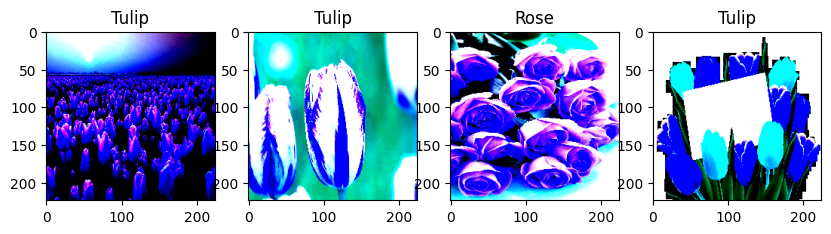

In [12]:
plt.figure(figsize = (10, 5))

for i, sample_batched in enumerate(train_loader):
    if i == 1:
        break
    for j in range(4):
        plt.subplot(1, 4, j + 1)
        plt.title('Rose' if sample_batched[1][j] == 0 else 'Tulip')
        plt.imshow(sample_batched[0][j].permute(1, 2, 0).numpy()[:, :, ::-1])

In [13]:
parameters = {'lr': [0.001, 0.01, 0.1],
              'batch_size' : [16, 32, 48]}

In [14]:
for lr in parameters['lr']:
    for bs in parameters['batch_size']:
        device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
        model = CNN().to(device)

        optimizer = optim.Adam(params=model.parameters(), lr=lr)
        criterion = nn.BCELoss(reduction='sum')

        train_loader = DataLoader(dataset=train_data, batch_size=bs, shuffle = True)
        test_loader = DataLoader(dataset=test_data, batch_size=bs, shuffle = False)
        valid_loader = DataLoader(dataset=valid_data, batch_size=bs, shuffle = False)

        epochs = 5

        train_accuracy_values = []
        train_loss_values = []

        val_accuracy_values = []
        val_loss_values = []

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}")
            model.train()
            epoch_loss = 0
            epoch_accuracy = 0

            epoch_val_loss = 0
            epoch_val_accuracy = 0

            for data, label in train_loader:
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

                epoch_accuracy += acc / len(train_data)
                epoch_loss += loss / len(train_data)

            model.eval()
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))
                acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

                epoch_val_accuracy += acc / len(valid_data)
                epoch_val_loss += loss / len(valid_data)

            val_accuracy_values.append(epoch_val_accuracy)
            val_loss_values.append(epoch_val_loss)

            train_accuracy_values.append(epoch_accuracy)
            train_loss_values.append(epoch_loss)

            print(f"Epoch {epoch + 1} end")

            print('Epoch: {}, train_accuracy: {}, train_loss: {}'.format(epoch + 1, epoch_accuracy, epoch_loss))
            print('Epoch: {}, valid_accuracy: {}, valid_loss: {}'.format(epoch + 1, epoch_val_accuracy, epoch_val_loss))

        train_loss_values = [value.cpu().detach().numpy() for value in train_loss_values]
        val_loss_values = [value.cpu().detach().numpy() for value in val_loss_values]

        plt.figure(figsize=(12,10))

        plt.subplot(2, 1, 1)
        plt.title(f"Train. Batch Size = {bs}, Learning Rate = {lr}")
        plt.plot(range(1, epochs + 1), train_accuracy_values, color = 'green')
        plt.plot(range(1, epochs + 1), train_loss_values, color = 'blue')
        plt.legend(['Accuracy', 'Loss'])
        plt.subplot(2, 1, 2)
        plt.title(f"Valid. Batch Size = {bs}, Learning Rate = {lr}")
        plt.plot(range(1, epochs + 1), val_accuracy_values, color = 'green')
        plt.plot(range(1, epochs + 1), val_loss_values, color = 'blue')
        plt.legend(['Accuracy', 'Loss'])

        #model.eval()
        test_loss = 0
        test_accuracy = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

            acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

            test_accuracy+=acc / len(test_data)
            test_loss+=loss / len(test_data)

        torch.save(model.state_dict(), os.path.join('C:\pp var 4\fifth', f"bs{bs}_lr{lr}_weight.pt"))

        print('LR: {}, BS: {}, test_accuracy: {}, test_loss: {}'.format(lr, bs, test_accuracy, test_loss))

Epoch 1


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


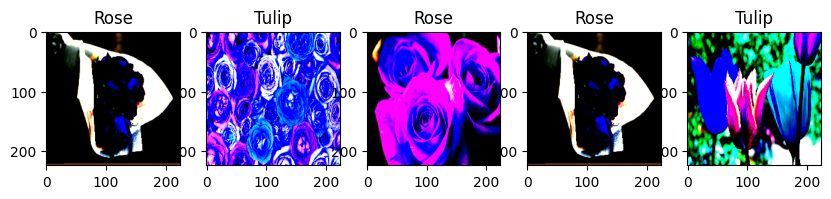

In [43]:
plt.figure(figsize=(10, 5))

for j in range(5):
  index = random.randint(0, 199)
  plt.subplot(1, 5, j + 1)
  plt.title("Rose" if (1 if  model(test_data[index][0].unsqueeze(dim=0).to(device))[0] >= 0.5 else 0) == 0 else "Tulip")
  plt.imshow(test_data[index][0].permute(1, 2, 0).numpy()[:, :, ::-1])